#                Assignment_05     
#                 **180427N** 




Import required libraries 

In [182]:

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

%matplotlib inline

In [183]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive



Load and visualize the template image and the convey belt

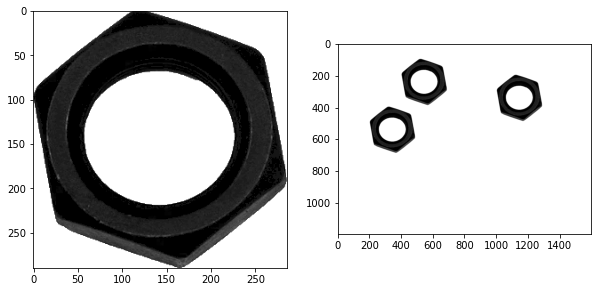

In [184]:
template_im = cv.imread(r'/content/drive/MyDrive/Colab_Notebooks/A5_images/template.png', cv.IMREAD_GRAYSCALE)
belt_im =  cv.imread(r'/content/drive/MyDrive/Colab_Notebooks/A5_images/belt.png', cv.IMREAD_GRAYSCALE)

fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()


# **Part 1**
**Apply Otsu's threshold**

138.0
138.0


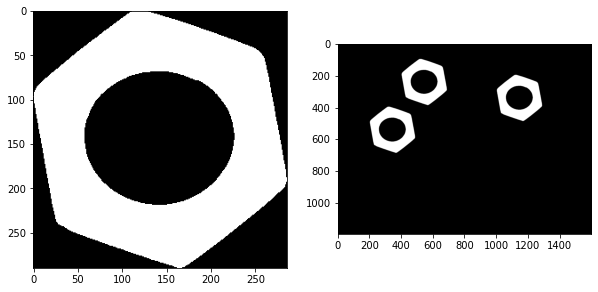

In [185]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU) 
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
print(th_t), print(th_b)
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(img_t, cmap='gray')
ax[1].imshow(img_b, cmap='gray')
plt.show()

**Morphological closing**

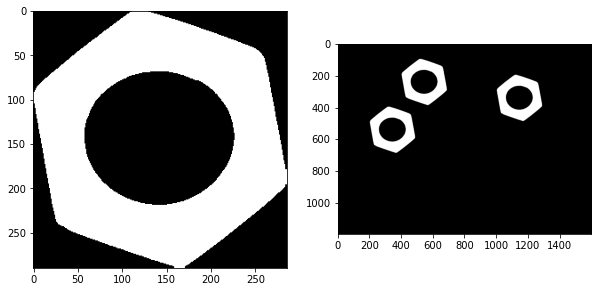

In [186]:
kernel = np.ones((3,3), dtype=np.uint8)
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(closing_t, cmap='gray')
ax[1].imshow(closing_b, cmap='gray')
plt.show()

**Connected component analysis**

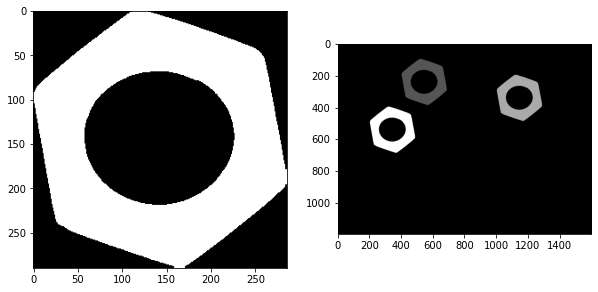

unique lables of t : 2
unique lables of b : 4
Stats of templete : 
 [[    0     0   286   290 42290]
 [    0     0   286   290 40650]]
Centroids of templete : 
 [[142.18770395 145.19172381]
 [142.82489545 143.780369  ]]
Stats of belt : 
 [[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]
Centroids of belt : 
 [[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]


In [187]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

# visuaize lables image 
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(labels_t, cmap='gray')
ax[1].imshow(labels_b, cmap='gray')
plt.show()

print("unique lables of t :", retval_t)
print("unique lables of b :", retval_b)

print('Stats of templete : \n', stats_t)
print('Centroids of templete : \n', centroids_t)
print('Stats of belt : \n', stats_b)
print('Centroids of belt : \n', centroids_b)

**• How many connected compoonets are detected in each image?** 

        Template image: 2 connected components (including the background)
        Belt image    : 4 connected components (including the background)
      
**• What are the statistics? Interpret these statistics.** 
        
        In the above code stat matrics gives some statistics about each connected components.  

        Column 1: cv.CC_STAT_LEFT: the leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction. 
        Column 2: cv.CC_STAT_TOP: the topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
        Column 3: cv.CC_STAT_WIDTH: the horizontal size of the bounding box.
        Column 4: cv.CC_STAT_HEIGHT: the vertical size of the bounding box.
        Column 5: cv.CC_STAT_AREA: the total area (in pixels) of the connected component.

**• What are the centroids?**

        Centroids matrics gives the centriod(x,y) of each lables. 
        eg. In template image there are two lables so its centroid matrics gives two centriods 

        



        


**Contour analysis**

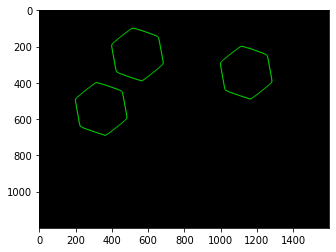

In [188]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) #extreme contours only
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Visualizing contours
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8') #-1 all contours
plt.imshow(conts)

**Count the number of matching hexagonal nuts in belt.png.**

In [189]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')   #binary image
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)  
for j,c in enumerate(belt_cont):
        print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0)) 
        #if shapes are same cv.matchShape returns values near zero

0.00010071698397151607
0.00010071698397928763
0.00010071698397484674


# **Part - II**
**Frame tracking through image moments.**

In [190]:
# contour area
ca = cv.contourArea(contours_b[1]) 
print(ca)

60059.5


In [191]:
# moments. centroids of contours_b[1]
M = cv.moments(contours_b[1])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

print("Centroids of the contour = ({},{})".format(cx,cy))


Centroids of the contour = (1142,343)


In [192]:
#
count=1  # no.of contours
object_prev_frame = [cx, cy, ca, count]

In [193]:
delta_x=15

# **Part III**
**1. Implement the function get_indexed_image, which takes an image as the input, performs thresholding, closing, and connected component analysis and return retval, labels, stats, centroids.**

In [194]:
def get_indexed_image(im):
    """ Thresholding, closing, and connected component analysis lumped
    """ 
    th_t, img_t = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU) #thresholding
    kernel = np.ones((3,3))  #kernel
    closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)  #Closing
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing_t) #connected component analysis
   
    return retval, labels, stats, centroids 

**2. Implement the function is_new, which checks the dissimilarity between 2 vectors.**

In [195]:
def is_new(a, b, delta, i):
    """ Vector Dissimilarity with an Array of Vectors
    Checks if vector b is similar to a one or more vectors in a outside the tolerances specified in delta. 
    vector i specifies which elements in b to compare with those in a. 
    """
    
    abs_diff = np.abs(a - b) #absolute different 
    abs_diff[:,i] = (abs_diff[:,i] > delta[i])  # for every rows checks the required column(i) is greater than delta[i]
    
    #print(abs_diff[:,i])
    return abs_diff[:,i].all() # if all the elements  of coloumn i are true it returns true
    
   

In [196]:
# check is_new  expected answer False

a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert is_new(a, b, delta, i) == False, " Check the function "

**3. If the array a is in the shape of (number of nuts , len(object_prev_frame)) ( i.e. array a is made by stacking all the object_prev_frame for each frame. If b is in the form of [cx, cy, ca, count], write the function prev_index to find the index of a particular nut in the previous frame.**

In [197]:
def prev_index(a, b, delta, i):
    """ Returns Previous Index
    Returns the index of the apppearance of the object in the previous frame.
    (See thee example in the next cell)
    """
    index = -1
    abs_diff = np.absolute(a - b) # absolute different
    abs_diff[:,i] = (abs_diff[:,i] <= delta[i]) # checks the simiarity between current nut and nuts of previous frame 

    index,_ = np.where(abs_diff[:,i]) # returns the index of the row where it is 1 of selected column i and some other details
  
    return index    


In [198]:
# check prev_index  expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
#print(a.shape)
delta = np.array([delta_x])
i = np.array([0])

assert prev_index(a,b,delta,i) == 1, " Check the function "

**Loading and Accessing each frame of the video**

In [199]:
cap = cv.VideoCapture('/content/drive/MyDrive/Colab_Notebooks/A5/conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
    print("Can't receive frame (stream end?). Exiting ...")
    break
  #cv2_imshow(frame)
  if cv.waitKey(1) == ord('q'):
    break
cap.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


**3. Implement a code to detect hexagonal nuts in a moving convey belt.**

Can't receive frame (stream end?). Exiting ...
Total number of nuts found in the video:  5


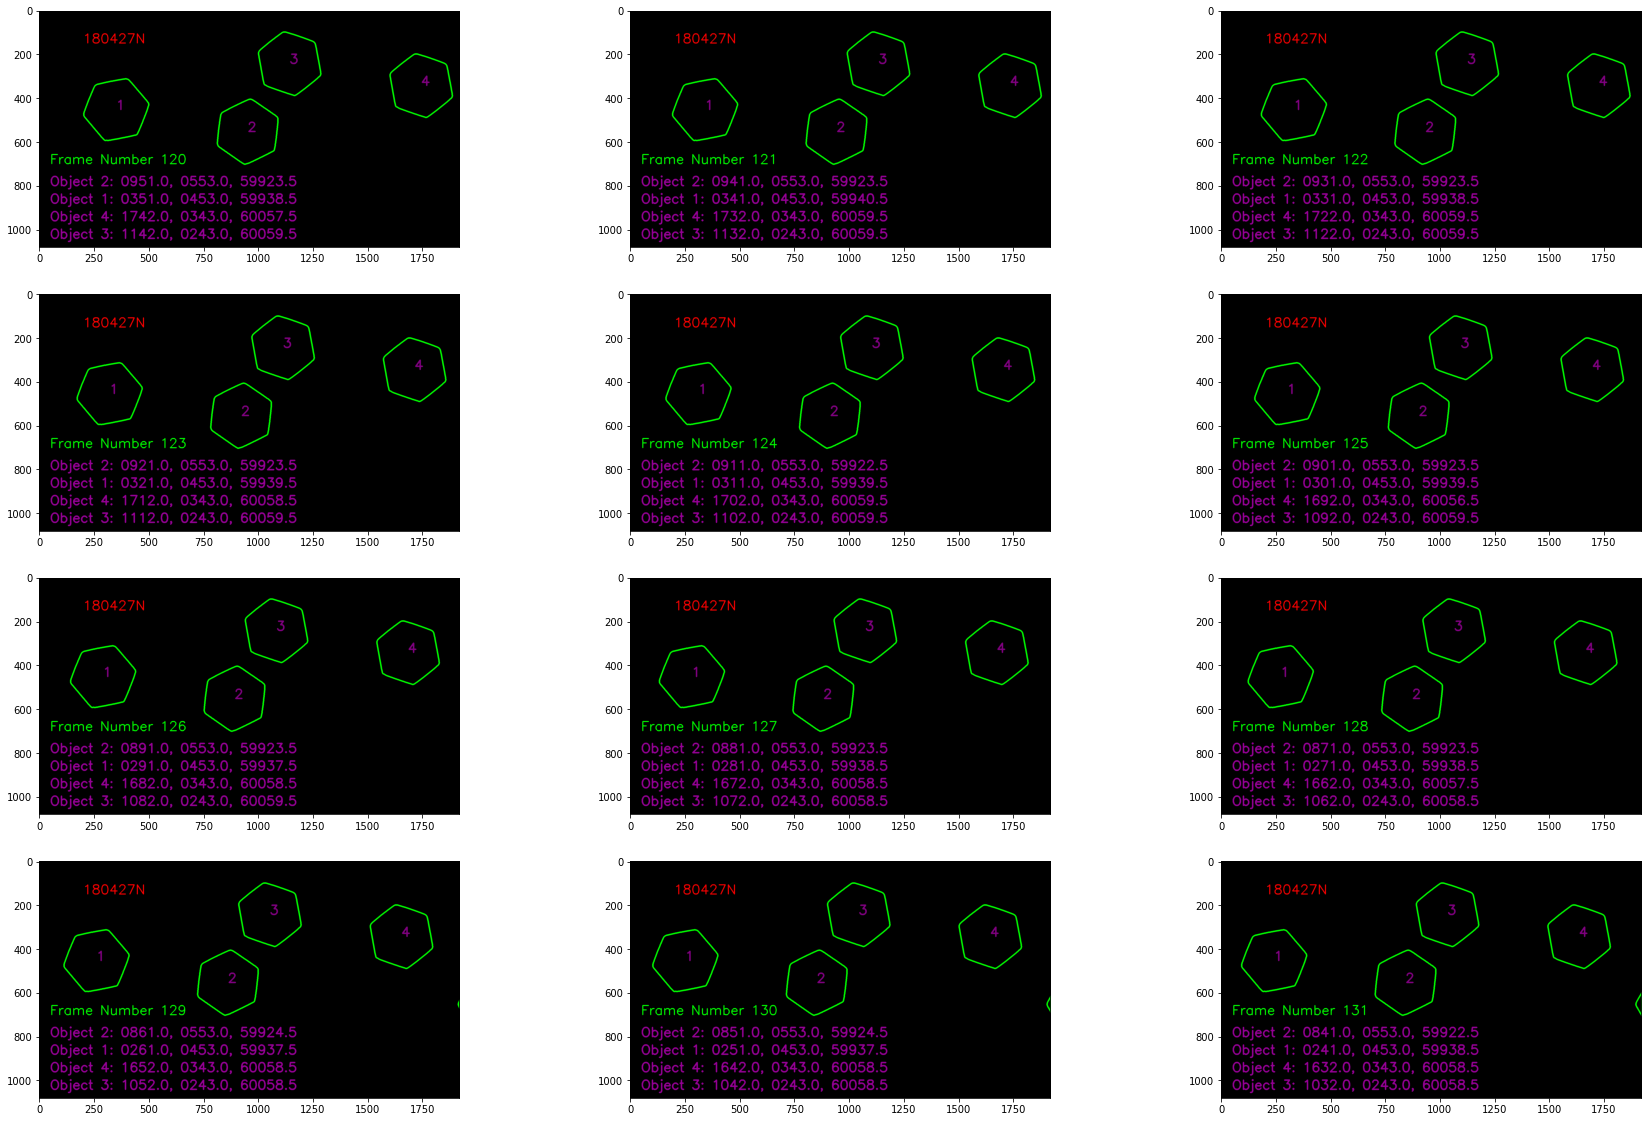

In [201]:
#Initializing required variables
total_nuts = 0
object_prev_frame = [np.array([.0,.0,.0,.0])]
frame_number = 0
plt.figure(figsize=(30,20))

cap = cv.VideoCapture('/content/drive/MyDrive/Colab_Notebooks/A5/conveyor_with_rotation.mp4') 

#creating video
width = int(cap.get(3))
height = int(cap.get(4))
frame_size = (width, height)
fourcc = cv.VideoWriter_fourcc(*'MP4V')
FPS = 10 # frame per seconds

out_obj = cv.VideoWriter('180427N_en2550_a05.mp4',fourcc, FPS , frame_size,True)

while cap.isOpened(): 
    ret, curr_frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    #cv2_imshow(frame)
    if cv.waitKey(1) == ord('q'):  
        break

    # Processing every frame
    grey = cv.cvtColor(curr_frame, cv.COLOR_BGR2GRAY) # convert color frame to grayscale
    retval, labels, stats, centroids = get_indexed_image(grey) #connected component analysis 
    label = 1 
    belt = ((labels >= 1)*255).astype('uint8')  #binary image
    contours,hierarchy  = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # drawable green color contours
    im_contours_belt = np.zeros((belt.shape[0],belt.shape[1],3), np.uint8)
    conts = cv.drawContours(im_contours_belt, contours, -1, (0,255,0), 5).astype('uint8')

    # Identify matching contours(objects)
    count = 0                    #no.of nuts in a frame
    object_curr_frame = []      #stores contours in current frame
    for contour in contours:
        
        match_t = cv.matchShapes(contours_t[0], contour, cv.CONTOURS_MATCH_I1, 0.0)
        if match_t < 0.5:  # matching threshold is 0.5
            M = cv.moments(contour)
            cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
            ca = cv.contourArea(contour)
            object_curr_frame.append(np.array([cx, cy, ca, count])) 
    
    # Counting the nuts present in the video
    delta_x = np.array([15])
    i = np.array([0])

    y = 0     # used to change the position of the annotation in y direction
    for nut in object_curr_frame: 
        # checks whether it is a new nut
        if is_new(object_prev_frame, nut, delta_x, i):
            total_nuts +=1        # if the nut is new
            nut[-1] = total_nuts  # assign total nut count(indices) to last element of the contour 

        else:
            # index of the nut in previous frame 
            prev_nut_idx = prev_index(object_prev_frame, nut, delta_x, i)
            
            #the corresponding index of the nut in previous frame assigned to current nut  
            nut[-1] = object_prev_frame[int(prev_nut_idx)][-1]  
      
        # Annotate the frames 
        # Annotate the index of each contour at its centroid 
        conts = cv.putText(conts, str(int(nut[-1])), (int(nut[0]),int(nut[1])), 
                         cv.FONT_HERSHEY_SIMPLEX, 2, (128,0,128), 5)
        
        # annotate in the actual video frame
        curr_frame = cv.putText(curr_frame , str(int(nut[-1])), (int(nut[0]),int(nut[1])), 
                         cv.FONT_HERSHEY_SIMPLEX, 2, (128,0,128), 5)
        
        
        # Annotate the cx, cy and contour area
        conts = cv.putText(conts, "Object {}: {:06.1f}, {:06.1f}, {:0.1f}".format(int(nut[-1]),nut[0],nut[1], nut[2]),
                      (50, 800+80*y), cv.FONT_HERSHEY_SIMPLEX, 2, (150,0,150), 5)
        
        curr_frame = cv.putText(curr_frame, "Object {}: {:06.1f}, {:06.1f}, {:0.1f}".format(int(nut[-1]),nut[0],nut[1], nut[2]),
                      (50, 800+80*y), cv.FONT_HERSHEY_SIMPLEX, 2, (150,0,150), 5)

        y += 1 #change the position 
    
    object_prev_frame = object_curr_frame # assign current frame to previous frame

    # Annotate frame number, index number in frames
    conts = cv.putText(conts, "Frame Number "+str(frame_number) , (50,700) , cv.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 3)    
    conts = cv.putText(conts, "180427N",(200,150),cv.FONT_HERSHEY_SIMPLEX, 2, (255,0, 0), 3) #Annotate index number

    # Annotate frame number, index number in actuval video
    curr_frame = cv.putText(curr_frame, "Frame Number "+str(frame_number) , (50,700) , cv.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 3)    
    curr_frame = cv.putText(curr_frame, "180427N",(200,150),cv.FONT_HERSHEY_SIMPLEX, 2, (255,0, 0), 3)
   
    object_prev_frame = object_curr_frame # assign current frame to previous frame

    # visualizing some frames
    if (120 <= frame_number < 132):
        plt.subplot(4,3, frame_number - 119)
        plt.imshow(conts)
  

    frame_number += 1 
    out_obj.write(curr_frame)


print("Total number of nuts found in the video: ",total_nuts)

cap.release()
out_obj.release()
cv.destroyAllWindows() 
              

In [202]:
!cp /content/drive/MyDrive/Colab_Notebooks/Ass_05.ipynb /content/

In [203]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.


In [204]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab_Notebooks/Ass_05.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/Ass_05.ipynb to PDF
[NbConvertApp] Support files will be in Ass_05_files/
[NbConvertApp] Making directory ./Ass_05_files
[NbConvertApp] Making directory ./Ass_05_files
[NbConvertApp] Making directory ./Ass_05_files
[NbConvertApp] Making directory ./Ass_05_files
[NbConvertApp] Making directory ./Ass_05_files
[NbConvertApp] Making directory ./Ass_05_files
[NbConvertApp] Writing 64026 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 374928 bytes to /content/drive/MyDrive/Colab_Notebooks/Ass_05.pdf
